In [66]:
import numpy as np
import matplotlib.pyplot as plt
import math as math

In [67]:
#Constants
gravity = 32.17405
R = 1545.348963;      # universal gas constant; units - ft*lbf/R*lb-mol
atm_to_psi = 14.6959; # units - psi/atm
Factor_of_Safety = 1.4;


In [68]:
# Rocket Inputs
#Thrust Chamber Design Parameters
# Using P_exit = 1, and plots from
# http://www.braeunig.us/space/comb-OM.htm P_Chamber, T_Chamber, y, Gas_Molecular_Weight can be extracted
#     after choosing the mixture ratio.
Characteristic_Length = 40    # units - inches; interpolated use table 4-1 from Huzel+Huang Modern Engineering for Design of LRES 
Thrust = 1000                 # units - pounds
T_Chamber_C = 2900.3          # Chamber temperature; units - Celcius
P_Chamber = 20*atm_to_psi     # Chamber pressure; units - atm
P_Exit =  0.82206329*atm_to_psi     # Exit pressure - sea level; units - atm
P_Ambient = 0.92*atm_to_psi   # Ambient pressure - sea level; units - atm
Mixture_Ratio = 2.62          # O/F mass ratio; unitless
Gas_Molecular_Weight = 18.833;# units - amu
y = 1.1510;                   # Ratio of Specific Heats - unitless
Working_Stress = 80000        # units - psi; yield stress of inconel walling
roughness = 20*10**-6.0*3.28084        #um -> ft

In [69]:
## Adiabatic Flame Temperature - Chamber Temperature; CONVERSIONS
T_Chamber_K = T_Chamber_C + 273.15; # units - Kelvin
T_Chamber_F = T_Chamber_C * 1.8 + 32; # units - Fahrenheit
T_Chamber_R = T_Chamber_F + 459.67; # units - Rankine

In [70]:

#Rocket Dimensions

#Rocket Body Dimensions
length_body = 70.31/12
diameter = 8/12
A_body = length_body*diameter*math.pi
A_ref = (diameter/2)**2*np.pi

#Nosecone Dimensions
length_cone = 36/12
coneAngle = math.atan(diameter/2/length_cone)
A_cone = np.pi*diameter/2*math.sqrt((diameter/2)**2+ (36/12)**2)

#Engine Dimenions
length_engine = 12/12
diameter_engine = 3.707/12
A_motor = np.pi*(diameter_engine/2)**2
A_engine = (np.pi*diameter/2*math.sqrt(
        (diameter/2)**2
        +(length_engine*(1+(diameter-diameter_engine)/diameter_engine))**2
    ) -np.pi*diameter_engine/2*math.sqrt(
        (diameter_engine/2)**2
        +(length_engine*(diameter-diameter_engine)/diameter_engine)**2
    ))

#Characterisitic Dimensions
length = length_engine+length_body+length_cone
A_rocket = A_body+A_engine

# Fin Dimensions
finThickness = .10/12
A_fins = 300/144*2*3*.25
meanChord = 15/12
leadingEdgeAngle = math.atan(1/2)
A_fin = finThickness*22.36/12*3*.5


#exhaustVelocity = 9154.2
M0 = 154.48 # wet mass
M1 = 113.44 # dry mass
mdot = 3.7448*3/4
print(A_cone,A_body,A_engine,A_fin,A_ref,A_fins,A_rocket)

3.1609257139331888 12.271409970772131 1.7198059593843174 0.023291666666666665 0.3490658503988659 3.125 13.991215930156448


In [71]:
def physStep(t0, t1, a0, v0, x0, burning):
    x1 = x0
    v1 = v0
    a1 = a0
    
    lx = 1000
    lv = 1000
    la = 1000
    pas = 0
    while (np.abs(lx-x1) > 1e-3) and (np.abs(lv-v1) > 1e-3):
        lx = x1
        lv = v1
        la = a1
        pas+=1
        if pas > 20:
            #code is stuck
            print(t0,t1,a0,v0,x0,burning)
            error()
            
        if burning:
            dv = (exhaustVelocity(x1)*np.log(M0/(M0 - mdot*t1))
                  -exhaustVelocity(x0)*np.log(M0/(M0 - mdot*t0))
                  -gravity*(t1-t0)
                  -math.copysign(1,v1)*axialDrag(v1,x1,burningBool)/(M0 - mdot*t1)*(t1-t0)
                 )
        else:
            dv = (-gravity*(t1-t0) 
                  -math.copysign(1,v1)*axialDrag(v1,x1,burningBool)/(M1)*(t1-t0)
                 )
        a1 = dv / (t1-t0)
        v1 = v0 + dv
        dx = v1 * (t1-t0)
        x1 = x0 + dx
    v = math.fabs(v1)
    M = v/math.sqrt(1.4*atmosphericPressure(x1)*144*gravity/atmosphericDensity(x1))

    #print('here now')
    return [a1, v1, x1]

In [72]:
def exhaustVelocity(h):
    R = 1545.348963;      # universal gas constant; units - ft*lbf/R*lb-mol
    T_Chamber_C = 2900.3;          # Chamber temperature; units - Celcius
    T_Chamber_R = T_Chamber_C*1.8+32+459.67;          # Chamber temperature; units - Celcius
    Gas_Molecular_Weight = 18.833; # units - amu
    y = 1.1510;                    # Ratio of Specific Heats - unitless
    P_Ambient = atmosphericPressure(h)
    Expansion_Ratio = (2/(y+1))**(1/(y-1)) * (P_Chamber/P_Exit)**(1/y) / ( (y+1)/(y-1) * (1 - (P_Exit/P_Chamber)**(1-1/y)) )**.5 # unitless
    c_star = (gravity*y*R*T_Chamber_R/Gas_Molecular_Weight)**(.5)/(y*((2/(y+1))**((y+1)/(y-1)))**.5) # ft/second
    lamda = .985
    Cf = lamda*( (2*y*y)/(y-1) * (2/(y+1))**((y+1)/(y-1)) * (1 - (P_Exit/P_Chamber)**((y-1)/y)) )**(1/2) + Expansion_Ratio*(P_Exit-P_Ambient)/P_Chamber
    return c_star*Cf*.8*math.sin(math.radians(80))


In [73]:
def axialDrag(v,x,burningBool):
    v = math.fabs(v)
    M = v/math.sqrt(1.4*atmosphericPressure(x)*144*gravity/atmosphericDensity(x))
    return (skinDragCoefficient(M,v,x)+noseDragCoefficient()+baseDragCoefficient(M,burningBool)+finEdgeDragCoefficient(M))*A_ref*0.5*atmosphericDensity(x)*v**2


In [74]:
def noseDragCoefficient():
    return 0.8*math.sin(coneAngle)**2*A_ref/A_ref

In [75]:
def skinDragCoefficient(M,v,x):
    reynolds = v*length/atmosphericKinematicViscosity(x)
    critReynolds = 51*(roughness/length)**-1.039
    #compression correction
    if M < 1:
        k = (1-0.1*M**2)
    else:
        k = (1+0.15*M**2)**-0.58-0.02211658591
    #coefficient friction
    if reynolds < 10^4:
        cf = 1.48*10**-2
    elif reynolds < critReynolds:
        cf = (1.5*np.log(reynolds) - 5.6)**-2
    else:
        cf = 0.032*(roughness/length)**0.2
        if k < (1+0.18*M**2)**-1:
            k = (1+0.18*M**2)**-1
    return k*cf*((1+(2*length/diameter)**-1)*A_rocket + (1+2*finThickness/meanChord)*A_fins)/A_ref

In [76]:
def baseDragCoefficient(M,burningBool):
    if M < 1:
        cd = 0.12+0.13*M**2
    else:
        cd = 0.25/M
    gamma = 0.5*length/(A_ref**0.5 - A_motor**0.5)
    if gamma < 1:
        k = 1
    elif gamma < 3:
        k = (3-gamma)/2
    else:
        return 0
    return cd*A_base(burningBool)/A_ref*k
def A_base(burningBool):
    if burningBool:
        return A_ref-A_motor
    else:
        return A_ref


In [77]:
def finEdgeDragCoefficient(M):
    if M < 0.9:
        cd = (1-M**2)**-0.417 -1
    elif M < 1:
        cd = 1 - 1.785*(M - 0.9)-0.00203318785
    else:
        cd = 1.214 - 0.502*M**-2 + 0.1095*M**-4 -0.0001785
    return cd*math.cos(leadingEdgeAngle)**2*A_fin/A_ref


In [78]:
def atmosphericKinematicViscosity(h):
    return 1.64*10**-4*atmosphericDensity(0)/atmosphericDensity(h)


In [79]:
def atmosphericDensity(h):
    h*=0.3048 # convert to meters
#    Pb, Tb, Lb, hb
    Rb = 8.3145
    g = 9.80665
    M = 0.0289644
    if h < 11000:
        Pb = 1.2250
        Tb = 288.15
        Lb = -0.0065
        hb = 0
    elif h < 20000:
        Pb = 0.36391
        Tb = 216.65
        hb = 11000
        return (Pb*0.062428)*math.exp(-g*M*(h - hb)/(Rb*Tb))
    elif h < 32000:
        Pb = 0.08803
        Tb = 216.65
        Lb = 0.001
        hb = 20000
    elif h < 47000:
        Pb = 0.01322
        Tb = 216.65
        Lb = 0.0028
        hb = 32000
    elif h < 51000:
        Pb = 0.00143
        Tb = 270.65
        hb = 47000
        return (Pb*0.062428)*math.exp(-g*M*(h - hb)/(Rb*Tb))
    elif h < 71000:
        Pb = 0.00086
        Tb = 270.65
        Lb = -0.0028
        hb = 51000
    else:
        Pb = .000064
        Tb = 214.65
        Lb = -0.002
        hb = 232940
    return (Pb*0.062428)*(Tb/(Tb+Lb*(h - hb)))**(1 + g*M/(Rb*Lb))

In [80]:
def atmosphericPressure(h):
#    Pb, Tb, Lb, hb
    Rb = 89494.596
    g = 32.17405
    M = 28.9644
    if h < 36089:
        Pb = 101325.00
        Tb = 288.15
        Lb = -0.0019812
        hb = 0
    elif h < 65617:
        Pb = 22632.10
        Tb = 216.65
        hb = 36089
        return (Pb/6894.76)*math.exp(-g*M*(h - hb)/(Rb*Tb))
    elif h < 104987:
        Pb = 5474.89
        Tb = 216.65
        Lb = 0.0003048
        hb = 65617
    elif h < 154199:
        Pb = 868.02
        Tb = 228.65
        Lb = 0.00085344
        hb = 104987
    elif h < 167323:
        Pb = 110.91
        Tb = 270.65
        hb = 154199
        return (Pb/6894.76)*math.exp(-g*M*(h - hb)/(Rb*Tb))
    elif h < 232940:
        Pb = 66.94
        Tb = 270.65
        Lb = -0.00085344
        hb = 167323
    else:
        Pb = 3.96
        Tb = 214.65
        Lb = -0.0006096
        hb = 232940
    return (Pb/6894.76)*(Tb/(Tb+Lb*(h - hb)))**(g*M/(Rb*Lb))

Max Velocity = 1553.07252286 ft/s
Max Altitude = 40239.0638364 ft


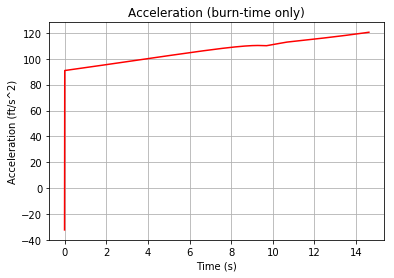

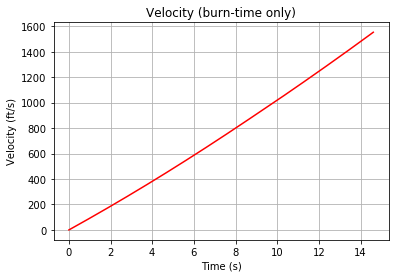

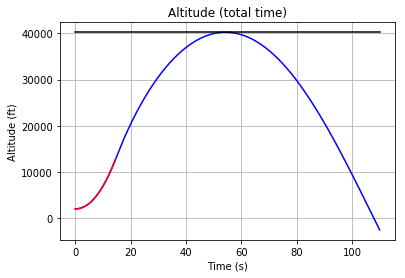

In [81]:
burnTime = 10.96*4/3# seconds
totalTime = 110 # seconds
totalSteps = totalTime*100
burnSteps = int(burnTime/totalTime*totalSteps)
coastSteps = totalSteps-burnSteps
burnTimeLinspace = np.linspace(0,burnTime,burnSteps)
totalTimeLinspace = np.linspace(0,totalTime,totalSteps)
acc = np.zeros([totalSteps]);
vel = np.zeros([totalSteps]);
pos = np.zeros([totalSteps]);

pos[0] = 2066;
acc[0] = -32.174;

# TAKES A WHILE, Run at your own risk
# posmax = 0
# bestP_Exit = 0
# for j in range(3*1470,9*1470,1):
#    P_Exit = j/1000
#    for i in range(1,burnSteps):
#        burningBool = True
#        [acc[i], vel[i], pos[i]] = physStep((i-1)*totalTime/totalSteps,i*totalTime/totalSteps,acc[0],vel[i-1],pos[i-1], burningBool);
#    temp = np.max(pos)
#    if temp > posmax:
#        posmax = temp
#        bestP_Exit = P_Exit
#        #print(j, bestP_Exit,temp)
# P_Exit = bestP_Exit
# print(P_Exit)
for i in range(1,burnSteps):
    burningBool = True
    [acc[i], vel[i], pos[i]] = physStep((i-1)*totalTime/totalSteps,i*totalTime/totalSteps,acc[0],vel[i-1],pos[i-1], burningBool);

for i in range(burnSteps,totalSteps):
    burningBool = False
    [acc[i], vel[i], pos[i]] = physStep((i-1)*totalTime/totalSteps,i*totalTime/totalSteps,acc[0],vel[i-1],pos[i-1], burningBool);

print('Max Velocity =', np.max(vel), 'ft/s')
print('Max Altitude =', np.max(pos), 'ft')

plt.figure(1)
plt.grid()
plt.title('Acceleration (burn-time only)')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (ft/s^2)')
plt.plot(burnTimeLinspace,acc[0:burnSteps],'r')

plt.figure(2)
plt.grid()
plt.title('Velocity (burn-time only)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (ft/s)')
plt.plot(burnTimeLinspace,vel[0:burnSteps],'r')

plt.figure(3)
plt.grid()
plt.title('Altitude (total time)')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (ft)')
plt.plot(totalTimeLinspace,pos,'b')
plt.plot(burnTimeLinspace,pos[0:burnSteps],'r')
plt.plot([0,totalTime],[np.max(pos),np.max(pos)], 'k')
plt.show()
